In [1]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load Stance-Labeled News Data

Load news articles with stance predictions from notebook 24.

In [3]:
# Paths
news_stance_dir = workspace_root / 'data' / '03_stance' / 'news'
news_polarization_dir = workspace_root / 'data' / '04_polarization' / 'news'
news_polarization_dir.mkdir(parents=True, exist_ok=True)

print(f"News stance data: {news_stance_dir}")
print(f"News polarization output: {news_polarization_dir}")

# Load articles with stance labels
stance_file = news_stance_dir / 'news_articles_with_stance.parquet'
if not stance_file.exists():
    raise FileNotFoundError(
        f"Stance-labeled data not found: {stance_file}\n"
        "Please run notebook 24 first to generate stance predictions."
    )

print(f"\n✓ Found stance-labeled data: {stance_file}")

News stance data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/news
News polarization output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news

✓ Found stance-labeled data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/news/news_articles_with_stance.parquet


In [4]:
# Load data
print("Loading stance-labeled articles...")
df = read_parquet(stance_file)

print(f"\n✓ Loaded {len(df):,} articles")
print(f"\nColumns: {df.columns.tolist()}")

# Show available columns
print(f"\nStance-related columns:")
stance_cols = [col for col in df.columns if 'stance' in col.lower()]
for col in stance_cols:
    print(f"  - {col}")

Loading stance-labeled articles...

✓ Loaded 2,559 articles

Columns: ['date', 'title', 'plain_text', 'requested_url', 'language', 'article_topic', 'max_similarity', 'stance_label', 'stance_label_id', 'stance_prob_pro', 'stance_prob_against', 'stance_prob_neutral', 'stance_confidence']

Stance-related columns:
  - stance_label
  - stance_label_id
  - stance_prob_pro
  - stance_prob_against
  - stance_prob_neutral
  - stance_confidence


In [5]:
# Data overview
print("Data overview:")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(pd.to_datetime(df['date'].max()) - pd.to_datetime(df['date'].min())).days}")

print(f"\nTopics: {df['article_topic'].nunique()}")
print(df['article_topic'].value_counts())

print(f"\nStance distribution:")
print(df['stance_label'].value_counts())
print(f"\nStance percentages:")
print(df['stance_label'].value_counts(normalize=True) * 100)

print(f"\nConfidence statistics:")
print(df['stance_confidence'].describe())

Data overview:

Date range: 2016-09-01 to 2016-10-31
Total days: 60

Topics: 5
article_topic
donald_trump      1569
gun_control        471
climate_change     222
immigration        190
vaccination        107
Name: count, dtype: int64

Stance distribution:
stance_label
against    1603
pro         700
neutral     256
Name: count, dtype: int64

Stance percentages:
stance_label
against    62.641657
pro        27.354435
neutral    10.003908
Name: proportion, dtype: float64

Confidence statistics:
count    2559.000000
mean        0.916967
std         0.138616
min         0.356335
25%         0.904036
50%         0.989228
75%         0.998407
max         0.999490
Name: stance_confidence, dtype: float64


## 2. Data Preparation

Prepare temporal aggregation and validate data quality.

In [6]:
# Ensure date column is proper datetime
print(f"Original date dtype: {df['date'].dtype}")

# Convert to datetime if needed
df['date'] = pd.to_datetime(df['date'])

# Extract temporal components
df['week'] = df['date'].dt.to_period('W')  # Week period object
df['year_month'] = df['date'].dt.to_period('M').astype(str)  # YYYY-MM format

print("✓ Added temporal columns")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")
print(f"Total weeks: {df['week'].nunique()}")

Original date dtype: object
✓ Added temporal columns

Date range: 2016-09-01 00:00:00 to 2016-10-31 00:00:00
Total days: 60
Total weeks: 10


In [7]:
# Check for missing values
print("Checking for missing values...")
missing_stance = df['stance_label'].isna().sum()
missing_topic = df['article_topic'].isna().sum()

print(f"\nMissing stance labels: {missing_stance}")
print(f"Missing topic labels: {missing_topic}")

if missing_stance > 0:
    print(f"\n⚠️  Warning: Removing {missing_stance} articles with missing stance labels")
    df = df[df['stance_label'].notna()].copy()

if missing_topic > 0:
    print(f"\n⚠️  Warning: Removing {missing_topic} articles with missing topic labels")
    df = df[df['article_topic'].notna()].copy()

print(f"\n✓ Clean dataset: {len(df):,} articles")

Checking for missing values...

Missing stance labels: 0
Missing topic labels: 0

✓ Clean dataset: 2,559 articles


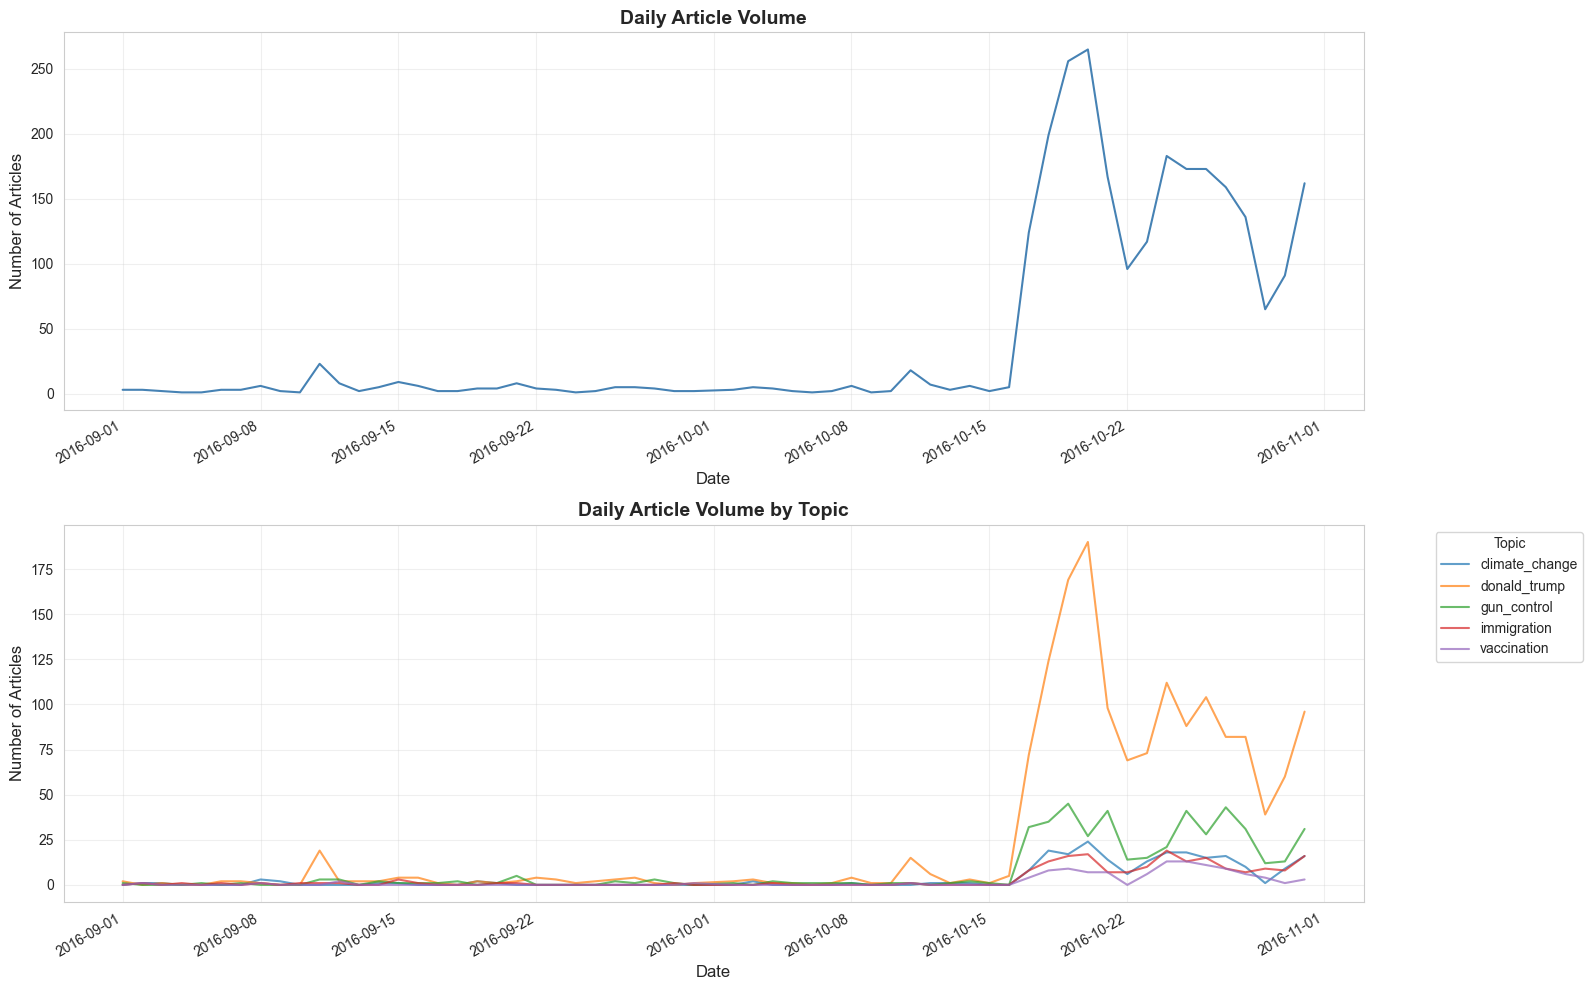

✓ Saved temporal coverage visualization


In [8]:
# Visualize temporal coverage
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily article volume
ax1 = axes[0]
daily_counts = df.groupby('date').size()
daily_counts.plot(ax=ax1, color='steelblue', linewidth=1.5)
ax1.set_title('Daily Article Volume', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.grid(alpha=0.3)

# Daily volume by topic
ax2 = axes[1]
daily_by_topic = df.groupby(['date', 'article_topic']).size().unstack(fill_value=0)
daily_by_topic.plot(ax=ax2, linewidth=1.5, alpha=0.7)
ax2.set_title('Daily Article Volume by Topic', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(news_polarization_dir / 'temporal_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved temporal coverage visualization")

## 3. Esteban-Ray Polarization Implementation

Implement the Esteban-Ray (1994) polarization measure (same as Reddit).

### Methodology

**Esteban-Ray Formula:**
$$P = K \sum_{i=1}^{n} \sum_{j=1}^{n} \pi_i^{1+\alpha} \pi_j |y_i - y_j|$$

**For Stance Detection Context:**
- **Groups**: pro, against, neutral
- **Positions on ideological scale**:
  - pro: +1.0 (supports topic)
  - against: -1.0 (opposes topic)
  - neutral: 0.0 (neutral/unclear)
- **α parameter**: 1.6 (standard value for polarization)
- **K normalization**: Set to 1.0

**Interpretation:**
- Higher values = more polarized
- Lower values = more consensus
- Considers both group sizes and ideological distance

In [9]:
def calculate_esteban_ray_polarization(stance_counts, alpha=1.6, positions=None):
    """
    Calculate Esteban-Ray polarization index for stance distribution.
    
    Parameters:
    -----------
    stance_counts : dict or pd.Series
        Counts of each stance (pro, against, neutral)
    alpha : float, default=1.6
        Polarization parameter (typically 1.0-2.0, standard is 1.6)
    positions : dict, optional
        Ideological positions for each stance
        Default: {'pro': 1.0, 'against': -1.0, 'neutral': 0.0}
    
    Returns:
    --------
    float : Esteban-Ray polarization index
    
    Notes:
    ------
    - Higher values indicate more polarization
    - Value range depends on stance distribution and alpha parameter
    - Returns 0.0 if insufficient data (< 2 articles)
    """
    # Default positions on ideological scale
    if positions is None:
        positions = {
            'pro': 1.0,
            'against': -1.0,
            'neutral': 0.0
        }
    
    # Convert to dict if Series
    if isinstance(stance_counts, pd.Series):
        stance_counts = stance_counts.to_dict()
    
    # Total articles
    total = sum(stance_counts.values())
    
    # Need at least 2 articles for polarization
    if total < 2:
        return 0.0
    
    # Calculate proportions
    proportions = {stance: count / total for stance, count in stance_counts.items()}
    
    # Calculate Esteban-Ray polarization
    polarization = 0.0
    
    for stance_i, pi in proportions.items():
        for stance_j, pj in proportions.items():
            # Get positions
            yi = positions.get(stance_i, 0.0)
            yj = positions.get(stance_j, 0.0)
            
            # Esteban-Ray formula: pi^(1+α) * pj * |yi - yj|
            polarization += (pi ** (1 + alpha)) * pj * abs(yi - yj)
    
    # K normalization constant (set to 1.0)
    K = 1.0
    
    return K * polarization

print("✓ Esteban-Ray polarization function defined")

# Test the function
print("\nTesting polarization calculation:")
test_cases = [
    {'pro': 100, 'against': 100, 'neutral': 0},  # Maximum polarization
    {'pro': 100, 'against': 0, 'neutral': 0},     # Consensus (all pro)
    {'pro': 50, 'against': 50, 'neutral': 50},    # Mixed distribution
    {'pro': 33, 'against': 33, 'neutral': 34},    # Balanced
]

for i, test in enumerate(test_cases, 1):
    pol = calculate_esteban_ray_polarization(test)
    print(f"  Test {i}: {test} → Polarization = {pol:.4f}")

✓ Esteban-Ray polarization function defined

Testing polarization calculation:
  Test 1: {'pro': 100, 'against': 100, 'neutral': 0} → Polarization = 0.3299
  Test 2: {'pro': 100, 'against': 0, 'neutral': 0} → Polarization = 0.0000
  Test 3: {'pro': 50, 'against': 50, 'neutral': 50} → Polarization = 0.1533
  Test 4: {'pro': 33, 'against': 33, 'neutral': 34} → Polarization = 0.1519


In [10]:
def calculate_polarization_metrics(stance_series, alpha=1.6):
    """
    Calculate comprehensive polarization metrics for a stance distribution.
    
    Parameters:
    -----------
    stance_series : pd.Series
        Series of stance labels (pro, against, neutral)
    alpha : float
        Esteban-Ray alpha parameter
    
    Returns:
    --------
    dict : Dictionary with polarization metrics
    """
    # Count stances
    stance_counts = stance_series.value_counts().to_dict()
    total = len(stance_series)
    
    # Ensure all stances are represented
    for stance in ['pro', 'against', 'neutral']:
        if stance not in stance_counts:
            stance_counts[stance] = 0
    
    # Calculate proportions
    proportions = {stance: count / total for stance, count in stance_counts.items()}
    
    # Calculate Esteban-Ray polarization
    er_polarization = calculate_esteban_ray_polarization(stance_counts, alpha=alpha)
    
    # Calculate additional metrics
    # 1. Bipolarity: proportion of pro + against (excludes neutral)
    bipolarity = (proportions['pro'] + proportions['against'])
    
    # 2. Balance: how balanced are pro and against?
    #    1.0 = perfectly balanced, 0.0 = completely one-sided
    if proportions['pro'] + proportions['against'] > 0:
        balance = 1 - abs(proportions['pro'] - proportions['against']) / (proportions['pro'] + proportions['against'])
    else:
        balance = 0.0
    
    # 3. Extremism: proportion in extreme positions (pro or against, not neutral)
    extremism = 1 - proportions['neutral']
    
    return {
        'total_articles': total,
        'er_polarization': er_polarization,
        'bipolarity': bipolarity,
        'balance': balance,
        'extremism': extremism,
        'prop_pro': proportions['pro'],
        'prop_against': proportions['against'],
        'prop_neutral': proportions['neutral'],
        'count_pro': stance_counts['pro'],
        'count_against': stance_counts['against'],
        'count_neutral': stance_counts['neutral']
    }

print("✓ Polarization metrics function defined")

✓ Polarization metrics function defined


## 4. Calculate Polarization by Topic

Calculate overall polarization for each topic.

In [11]:
# Calculate polarization for each topic
print("Calculating polarization by topic...")

topic_polarization = []

for topic in df['article_topic'].unique():
    topic_data = df[df['article_topic'] == topic]
    metrics = calculate_polarization_metrics(topic_data['stance_label'])
    metrics['topic'] = topic
    topic_polarization.append(metrics)

topic_pol_df = pd.DataFrame(topic_polarization)

print("\n" + "="*80)
print("POLARIZATION BY TOPIC")
print("="*80)
print("\n", topic_pol_df[[
    'topic', 'total_articles', 'er_polarization', 
    'bipolarity', 'balance', 'extremism'
]].to_string(index=False))

# Sort by polarization
topic_pol_df = topic_pol_df.sort_values('er_polarization', ascending=False)

print("\n" + "="*80)
print("RANKING (by Esteban-Ray Polarization)")
print("="*80)
for i, row in enumerate(topic_pol_df.itertuples(), 1):
    print(f"\n{i}. {row.topic}")
    print(f"   Polarization: {row.er_polarization:.4f}")
    print(f"   Bipolarity: {row.bipolarity:.3f} | Balance: {row.balance:.3f} | Extremism: {row.extremism:.3f}")
    print(f"   Distribution: {row.prop_pro:.1%} pro, {row.prop_against:.1%} against, {row.prop_neutral:.1%} neutral")

Calculating polarization by topic...

POLARIZATION BY TOPIC

          topic  total_articles  er_polarization  bipolarity  balance  extremism
  donald_trump            1569         0.206456    0.856597 0.433036   0.856597
   gun_control             471         0.126770    0.980892 0.142857   0.980892
climate_change             222         0.008905    1.000000 0.009009   1.000000
   vaccination             107         0.259597    0.953271 0.529412   0.953271
   immigration             190         0.259821    0.910526 0.924855   0.910526

RANKING (by Esteban-Ray Polarization)

1. immigration
   Polarization: 0.2598
   Bipolarity: 0.911 | Balance: 0.925 | Extremism: 0.911
   Distribution: 42.1% pro, 48.9% against, 8.9% neutral

2. vaccination
   Polarization: 0.2596
   Bipolarity: 0.953 | Balance: 0.529 | Extremism: 0.953
   Distribution: 70.1% pro, 25.2% against, 4.7% neutral

3. donald_trump
   Polarization: 0.2065
   Bipolarity: 0.857 | Balance: 0.433 | Extremism: 0.857
   Distribution

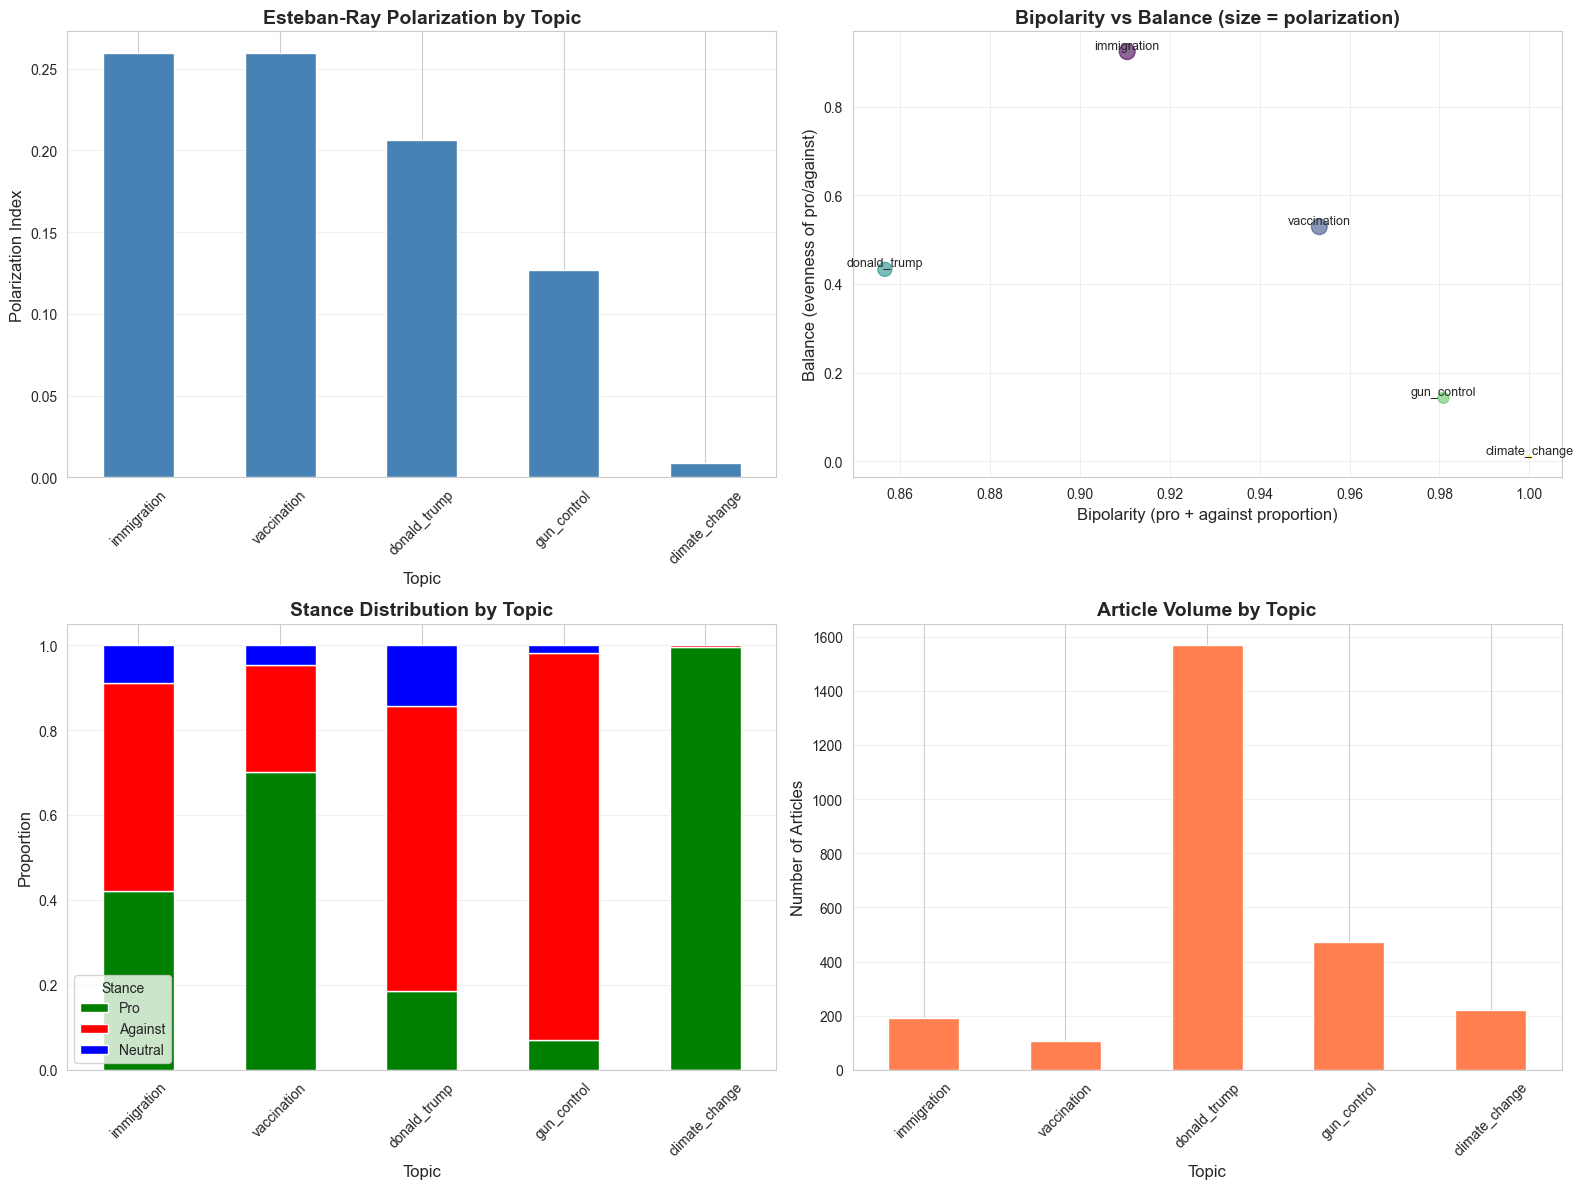

✓ Saved polarization visualizations


In [12]:
# Visualize topic polarization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Esteban-Ray Polarization by topic
ax = axes[0, 0]
topic_pol_df.plot(x='topic', y='er_polarization', kind='bar', ax=ax, color='steelblue', legend=False)
ax.set_title('Esteban-Ray Polarization by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Polarization Index', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 2. Bipolarity vs Balance
ax = axes[0, 1]
scatter = ax.scatter(
    topic_pol_df['bipolarity'], 
    topic_pol_df['balance'],
    s=topic_pol_df['er_polarization']*500,  # Size by polarization
    alpha=0.6,
    c=range(len(topic_pol_df)),
    cmap='viridis'
)
for _, row in topic_pol_df.iterrows():
    ax.annotate(
        row['topic'],
        (row['bipolarity'], row['balance']),
        fontsize=9,
        ha='center',
        va='bottom'
    )
ax.set_title('Bipolarity vs Balance (size = polarization)', fontsize=14, fontweight='bold')
ax.set_xlabel('Bipolarity (pro + against proportion)', fontsize=12)
ax.set_ylabel('Balance (evenness of pro/against)', fontsize=12)
ax.grid(alpha=0.3)

# 3. Stance distribution by topic
ax = axes[1, 0]
stance_props = topic_pol_df[['topic', 'prop_pro', 'prop_against', 'prop_neutral']].set_index('topic')
stance_props.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red', 'blue'])
ax.set_title('Stance Distribution by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.legend(title='Stance', labels=['Pro', 'Against', 'Neutral'])
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 4. Article volume by topic
ax = axes[1, 1]
topic_pol_df.plot(x='topic', y='total_articles', kind='bar', ax=ax, color='coral', legend=False)
ax.set_title('Article Volume by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Number of Articles', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(news_polarization_dir / 'polarization_by_topic.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved polarization visualizations")

## 5. Calculate Temporal Polarization (Daily)

Calculate polarization over time for trend analysis and forecasting.

In [13]:
# Calculate daily polarization by topic
print("Calculating daily polarization time series...")

daily_polarization = []

for topic in df['article_topic'].unique():
    topic_data = df[df['article_topic'] == topic]
    
    for date, date_data in topic_data.groupby('date'):
        metrics = calculate_polarization_metrics(date_data['stance_label'])
        metrics['topic'] = topic
        metrics['date'] = date
        daily_polarization.append(metrics)

daily_pol_df = pd.DataFrame(daily_polarization)
daily_pol_df = daily_pol_df.sort_values(['topic', 'date'])

print(f"\n✓ Calculated polarization for {len(daily_pol_df):,} topic-date combinations")
print(f"\nDate range: {daily_pol_df['date'].min()} to {daily_pol_df['date'].max()}")
print(f"Topics: {daily_pol_df['topic'].nunique()}")

# Summary statistics
print("\nDaily polarization summary:")
print(daily_pol_df[['er_polarization', 'bipolarity', 'balance', 'extremism']].describe())

Calculating daily polarization time series...

✓ Calculated polarization for 170 topic-date combinations

Date range: 2016-09-01 00:00:00 to 2016-10-31 00:00:00
Topics: 5

Daily polarization summary:
       er_polarization  bipolarity     balance   extremism
count       170.000000  170.000000  170.000000  170.000000
mean          0.099921    0.917890    0.217619    0.917890
std           0.118936    0.202201    0.313586    0.202201
min           0.000000    0.000000    0.000000    0.000000
25%           0.000000    0.926683    0.000000    0.926683
50%           0.000000    1.000000    0.000000    1.000000
75%           0.204667    1.000000    0.428181    1.000000
max           0.329877    1.000000    1.000000    1.000000


In [14]:
# Filter days with minimum article threshold
MIN_ARTICLES_PER_DAY = 10  # Minimum articles for reliable polarization estimate

daily_pol_filtered = daily_pol_df[daily_pol_df['total_articles'] >= MIN_ARTICLES_PER_DAY].copy()

print(f"Filtering days with < {MIN_ARTICLES_PER_DAY} articles...")
print(f"\nBefore: {len(daily_pol_df):,} topic-dates")
print(f"After:  {len(daily_pol_filtered):,} topic-dates")
print(f"Removed: {len(daily_pol_df) - len(daily_pol_filtered):,} ({(len(daily_pol_df) - len(daily_pol_filtered))/len(daily_pol_df)*100:.1f}%)")

print("\nDays per topic (after filtering):")
print(daily_pol_filtered.groupby('topic').size())

Filtering days with < 10 articles...

Before: 170 topic-dates
After:  54 topic-dates
Removed: 116 (68.2%)

Days per topic (after filtering):
topic
climate_change    11
donald_trump      17
gun_control       15
immigration        8
vaccination        3
dtype: int64


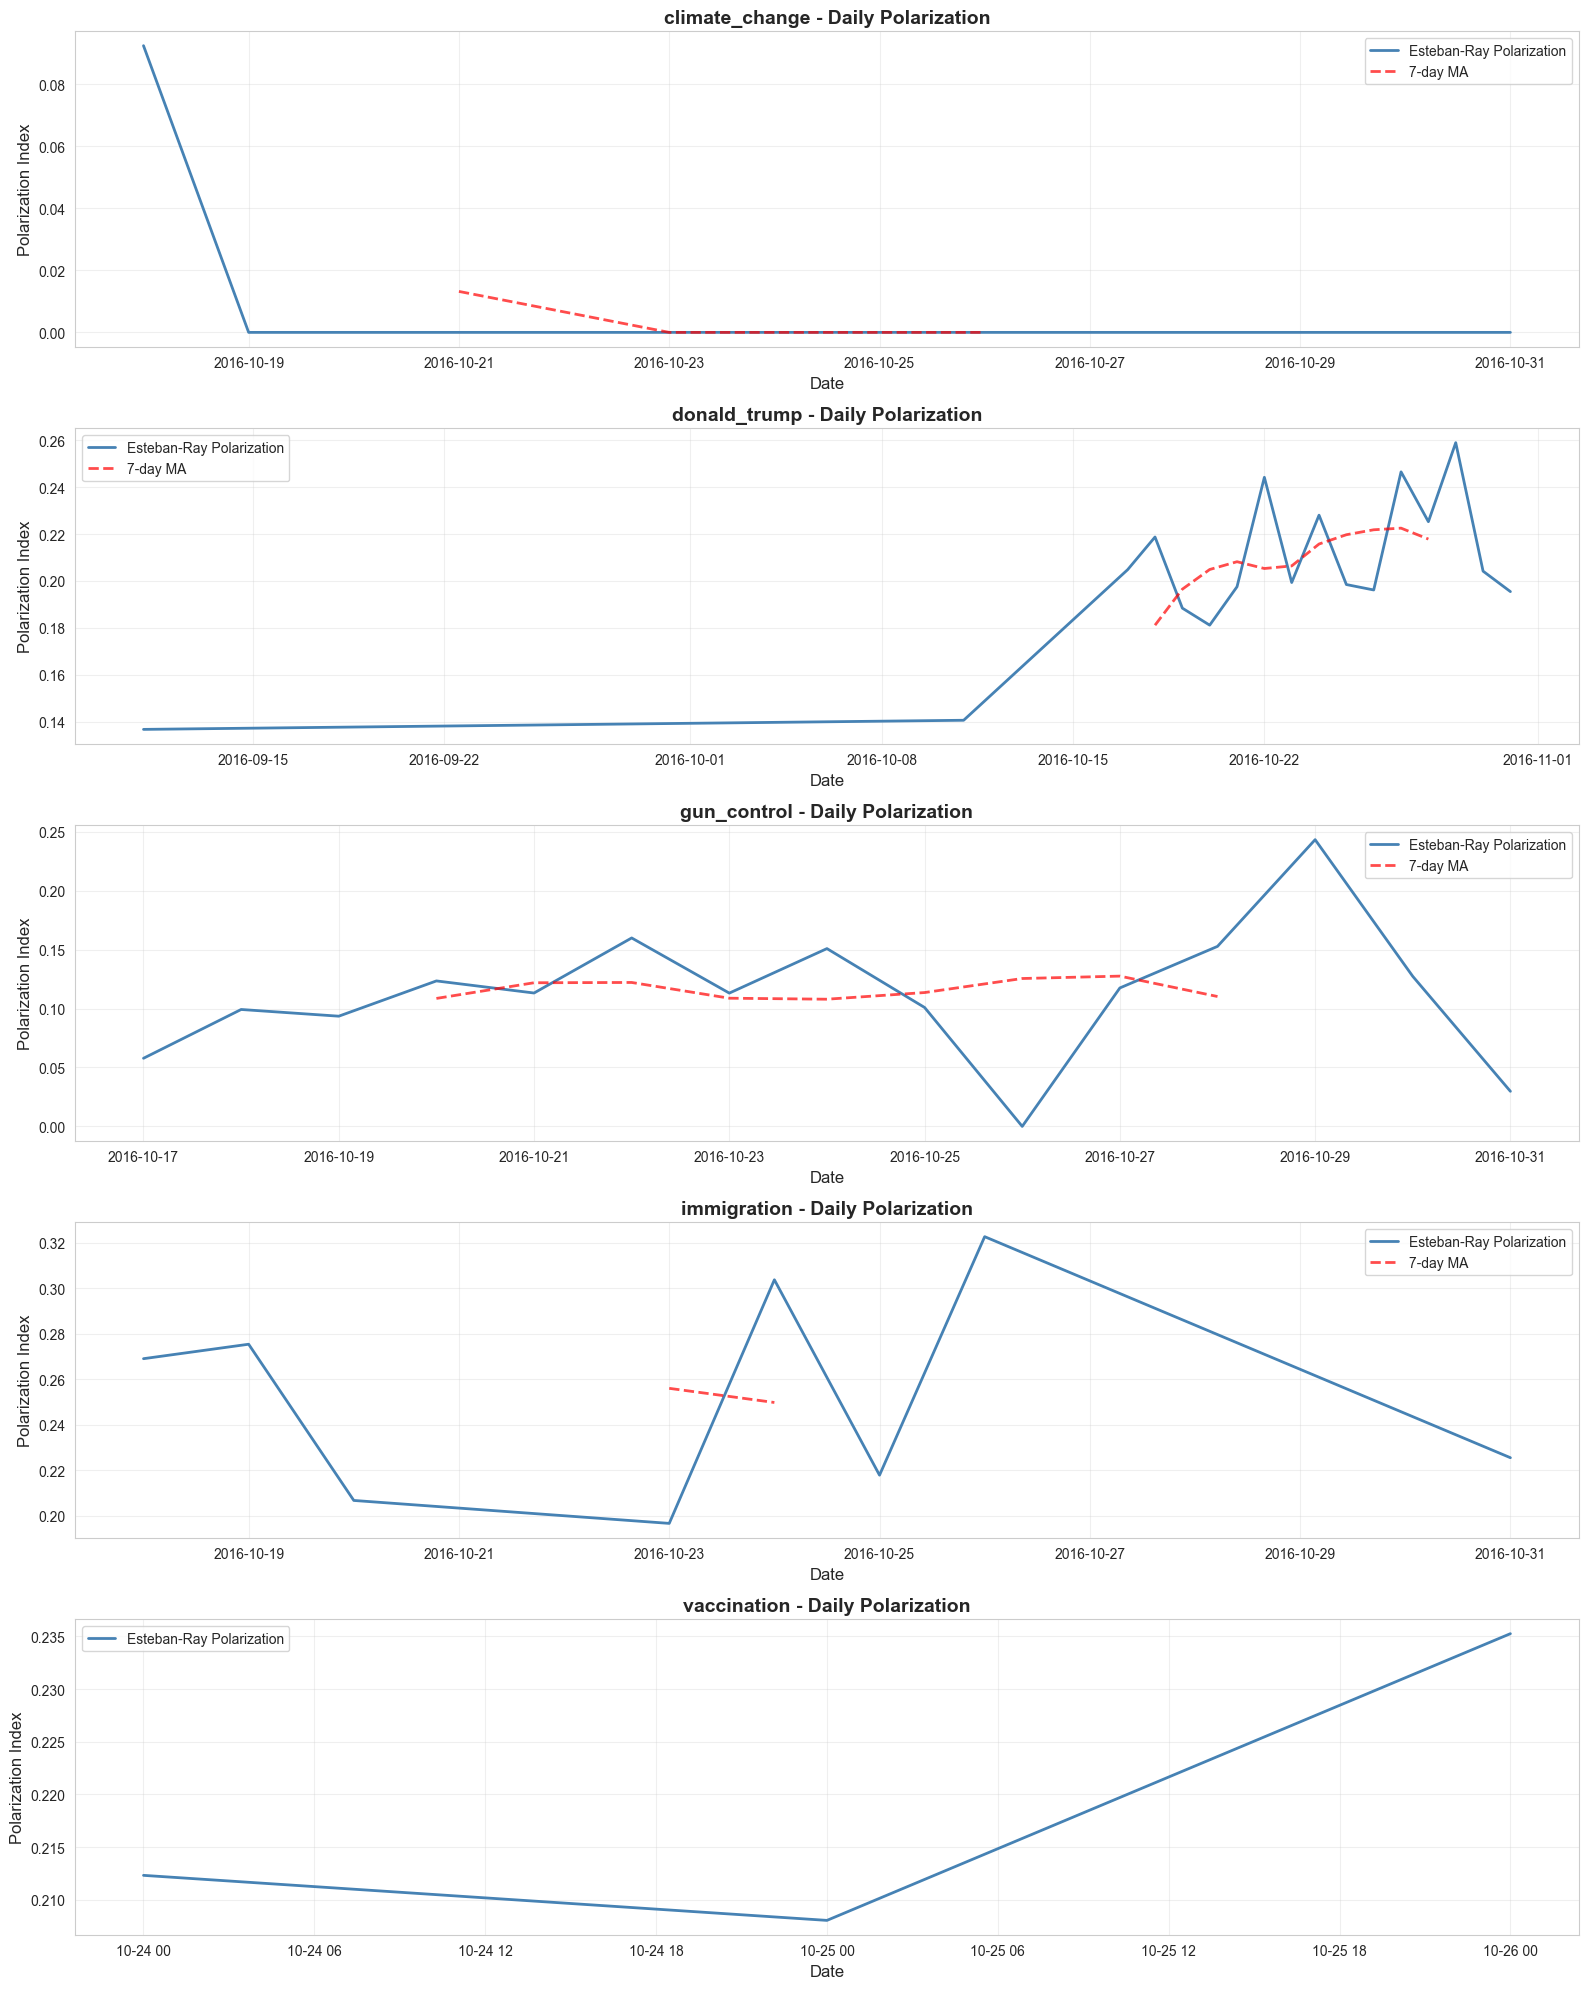

✓ Saved daily polarization time series


In [15]:
# Visualize daily polarization time series
topics = sorted(daily_pol_filtered['topic'].unique())
n_topics = len(topics)

fig, axes = plt.subplots(n_topics, 1, figsize=(16, 4*n_topics))
if n_topics == 1:
    axes = [axes]

for ax, topic in zip(axes, topics):
    topic_data = daily_pol_filtered[daily_pol_filtered['topic'] == topic].copy()
    topic_data = topic_data.sort_values('date')
    
    # Plot polarization
    ax.plot(topic_data['date'], topic_data['er_polarization'], 
            linewidth=2, color='steelblue', label='Esteban-Ray Polarization')
    
    # Add 7-day moving average
    if len(topic_data) >= 7:
        ma7 = topic_data['er_polarization'].rolling(window=7, center=True).mean()
        ax.plot(topic_data['date'], ma7, 
                linewidth=2, color='red', linestyle='--', alpha=0.7, label='7-day MA')
    
    ax.set_title(f'{topic} - Daily Polarization', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Polarization Index', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(news_polarization_dir / 'daily_polarization_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved daily polarization time series")

## 6. Calculate Temporal Polarization (Weekly)

Weekly aggregation for smoother trends and forecasting.

In [16]:
# Calculate weekly polarization by topic
print("Calculating weekly polarization time series...")

weekly_polarization = []

for topic in df['article_topic'].unique():
    topic_data = df[df['article_topic'] == topic]
    
    for week, week_data in topic_data.groupby('week'):
        metrics = calculate_polarization_metrics(week_data['stance_label'])
        metrics['topic'] = topic
        metrics['week'] = week
        metrics['week_start'] = week.start_time
        weekly_polarization.append(metrics)

weekly_pol_df = pd.DataFrame(weekly_polarization)
weekly_pol_df = weekly_pol_df.sort_values(['topic', 'week'])

print(f"\n✓ Calculated polarization for {len(weekly_pol_df):,} topic-week combinations")
print(f"\nWeek range: {weekly_pol_df['week'].min()} to {weekly_pol_df['week'].max()}")
print(f"Total weeks: {weekly_pol_df['week'].nunique()}")

# Filter weeks with minimum articles
MIN_ARTICLES_PER_WEEK = 30
weekly_pol_filtered = weekly_pol_df[weekly_pol_df['total_articles'] >= MIN_ARTICLES_PER_WEEK].copy()

print(f"\nFiltering weeks with < {MIN_ARTICLES_PER_WEEK} articles...")
print(f"After filtering: {len(weekly_pol_filtered):,} topic-weeks")
print("\nWeeks per topic:")
print(weekly_pol_filtered.groupby('topic').size())

Calculating weekly polarization time series...

✓ Calculated polarization for 47 topic-week combinations

Week range: 2016-08-29/2016-09-04 to 2016-10-31/2016-11-06
Total weeks: 10

Filtering weeks with < 30 articles...
After filtering: 13 topic-weeks

Weeks per topic:
topic
climate_change    2
donald_trump      4
gun_control       3
immigration       2
vaccination       2
dtype: int64


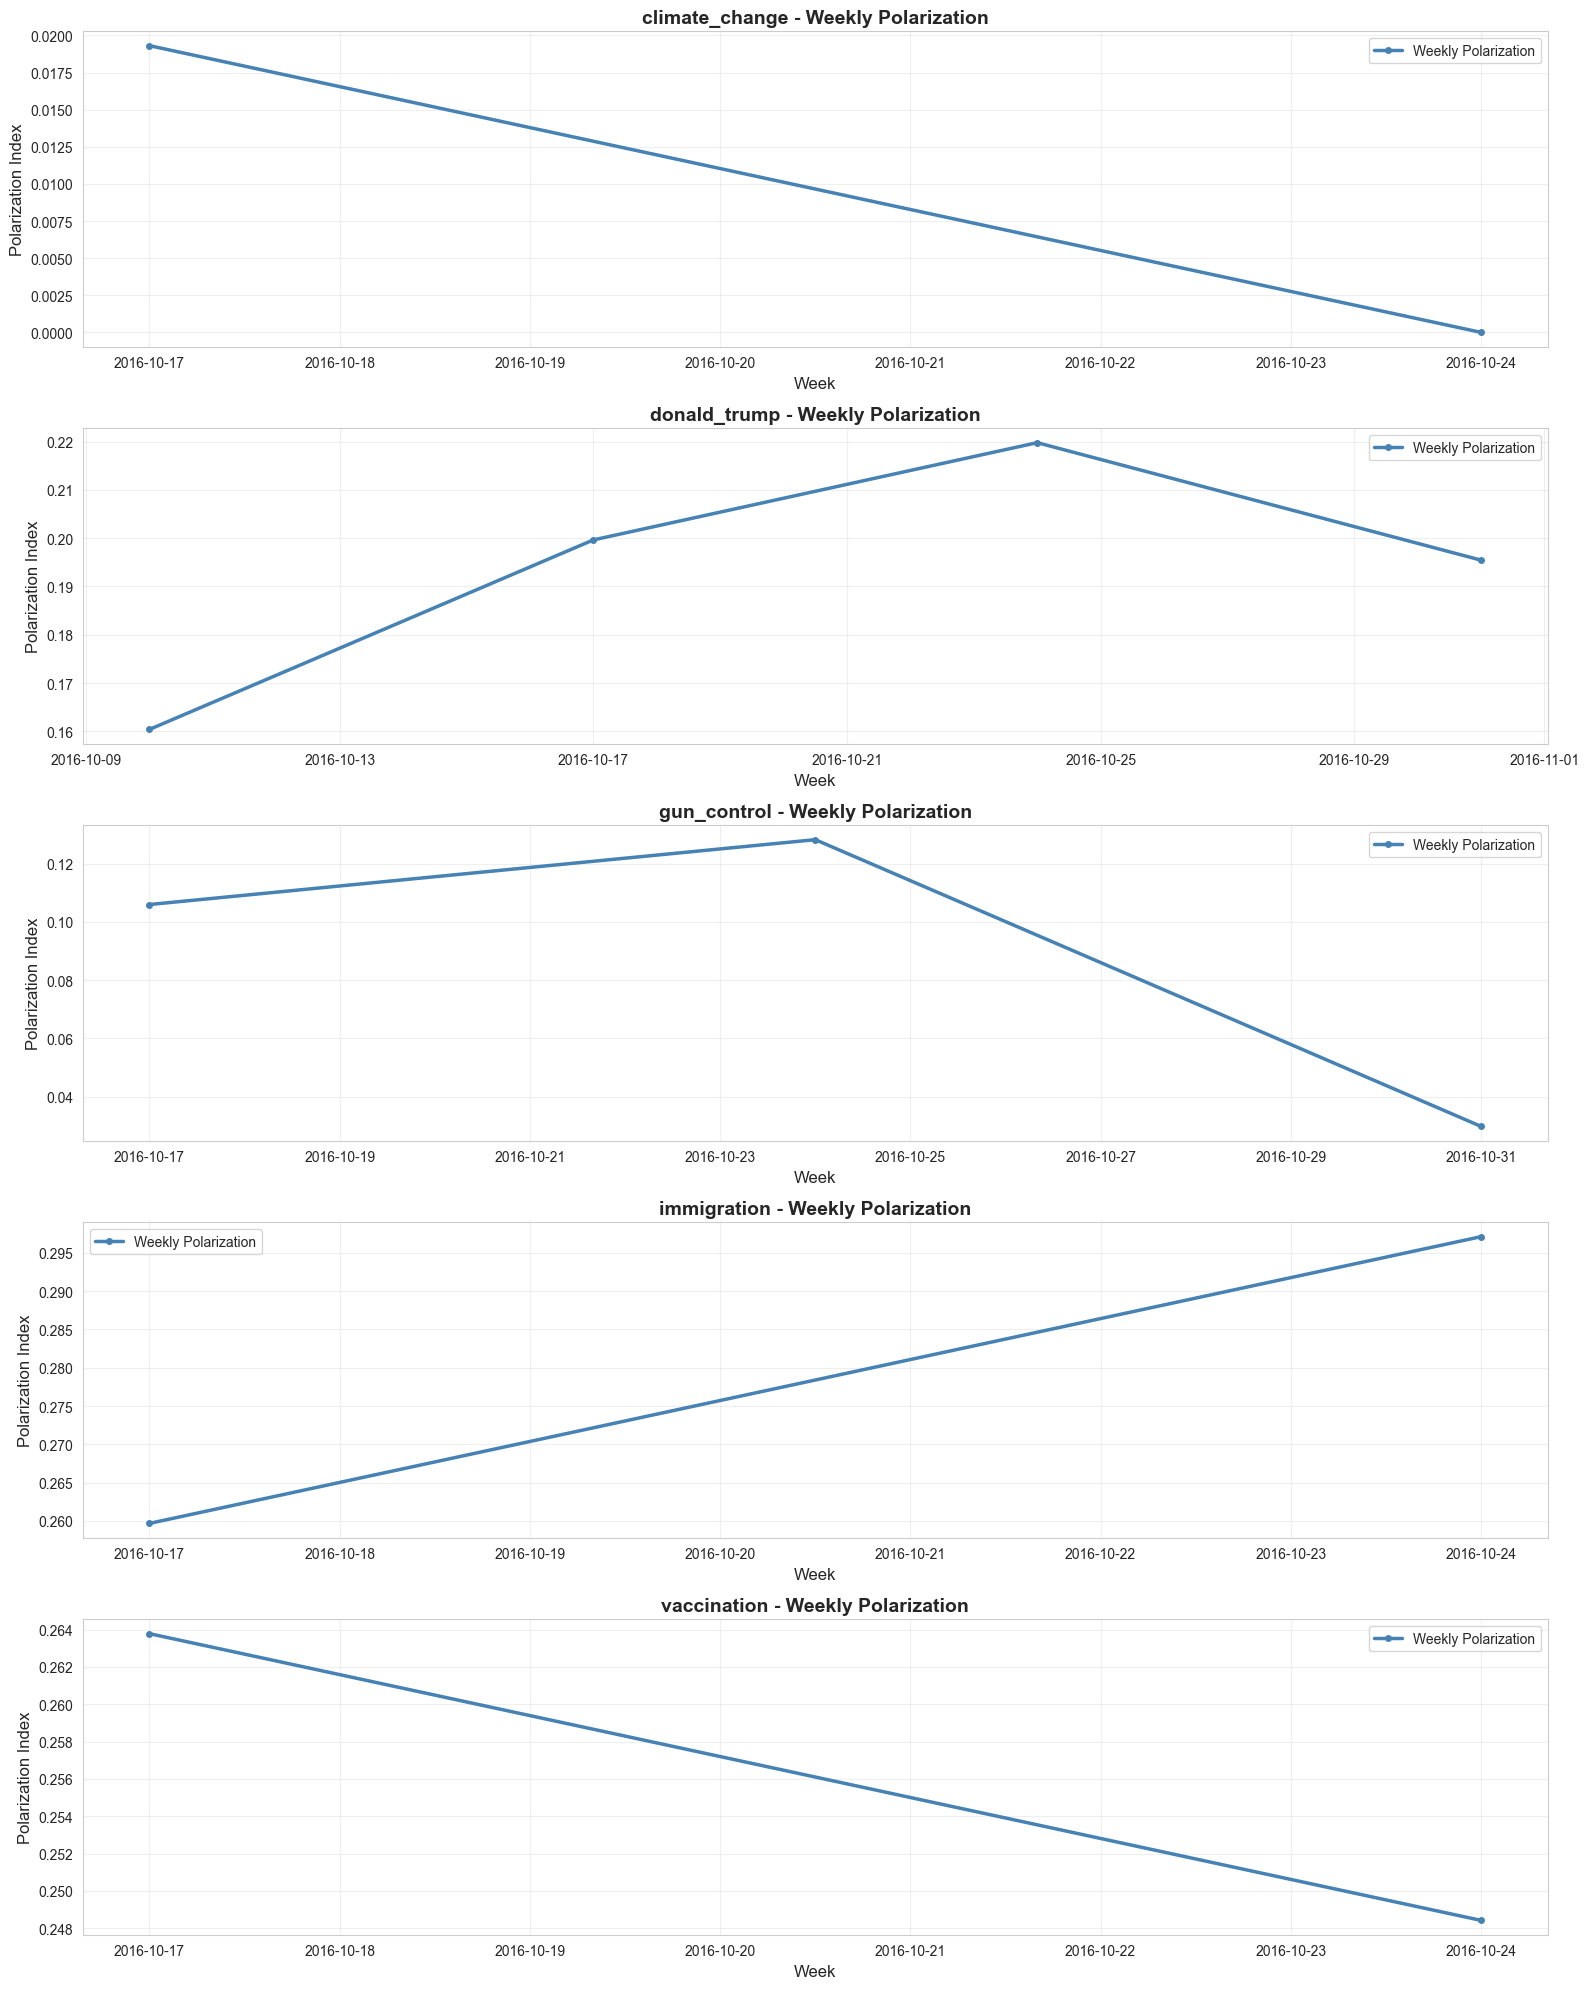

✓ Saved weekly polarization time series


In [17]:
# Visualize weekly polarization time series
topics = sorted(weekly_pol_filtered['topic'].unique())
n_topics = len(topics)

fig, axes = plt.subplots(n_topics, 1, figsize=(16, 4*n_topics))
if n_topics == 1:
    axes = [axes]

for ax, topic in zip(axes, topics):
    topic_data = weekly_pol_filtered[weekly_pol_filtered['topic'] == topic].copy()
    topic_data = topic_data.sort_values('week_start')
    
    # Plot polarization
    ax.plot(topic_data['week_start'], topic_data['er_polarization'], 
            linewidth=2.5, color='steelblue', marker='o', markersize=4, 
            label='Weekly Polarization')
    
    ax.set_title(f'{topic} - Weekly Polarization', fontsize=14, fontweight='bold')
    ax.set_xlabel('Week', fontsize=12)
    ax.set_ylabel('Polarization Index', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(news_polarization_dir / 'weekly_polarization_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved weekly polarization time series")

## 7. Polarization Correlation Analysis

Analyze relationships between polarization metrics and other variables.

Analyzing correlations between polarization metrics...



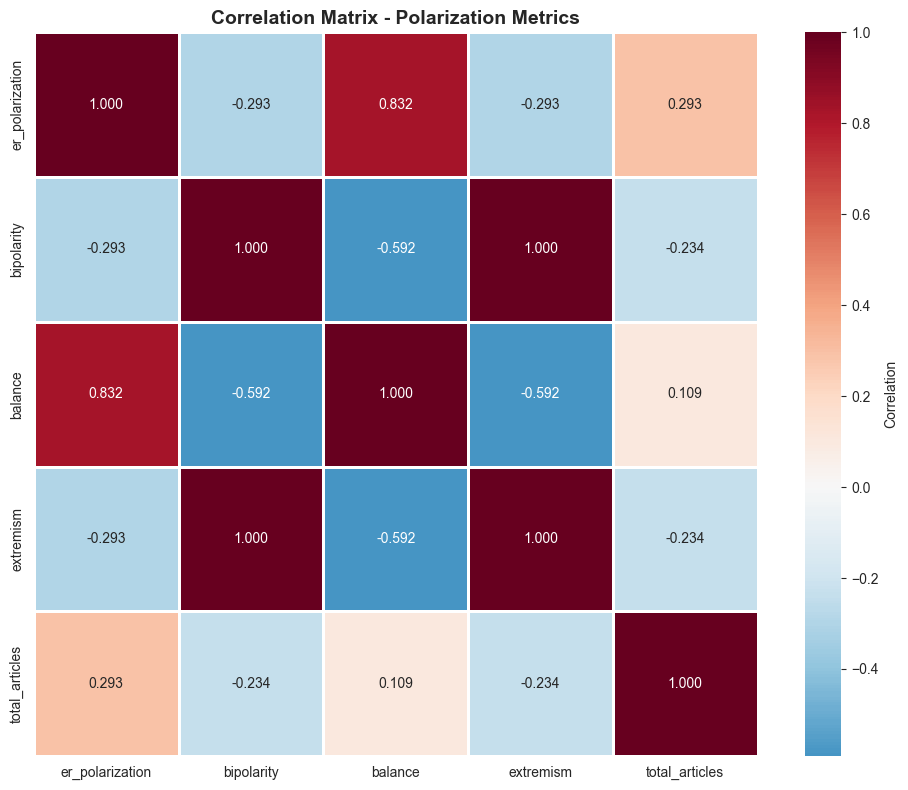


Correlation with Esteban-Ray Polarization:
er_polarization    1.000000
balance            0.831614
total_articles     0.292706
bipolarity        -0.293483
extremism         -0.293483
Name: er_polarization, dtype: float64


In [18]:
# Correlation between polarization metrics
print("Analyzing correlations between polarization metrics...\n")

metrics_cols = ['er_polarization', 'bipolarity', 'balance', 'extremism', 'total_articles']
corr_matrix = daily_pol_filtered[metrics_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Matrix - Polarization Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(news_polarization_dir / 'polarization_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelation with Esteban-Ray Polarization:")
print(corr_matrix['er_polarization'].sort_values(ascending=False))

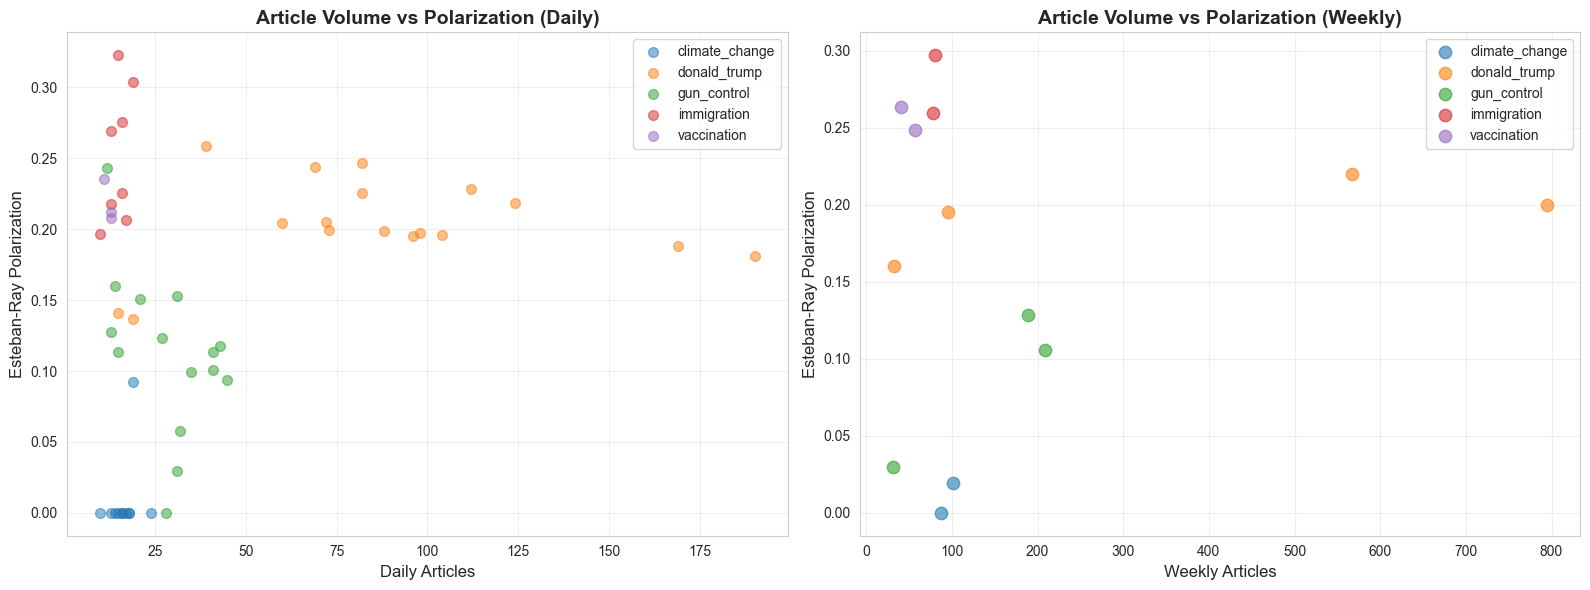

✓ Saved volume vs polarization analysis


In [19]:
# Relationship between volume and polarization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Daily volume vs polarization
ax = axes[0]
for topic in sorted(daily_pol_filtered['topic'].unique()):
    topic_data = daily_pol_filtered[daily_pol_filtered['topic'] == topic]
    ax.scatter(
        topic_data['total_articles'],
        topic_data['er_polarization'],
        alpha=0.5,
        label=topic,
        s=50
    )
ax.set_title('Article Volume vs Polarization (Daily)', fontsize=14, fontweight='bold')
ax.set_xlabel('Daily Articles', fontsize=12)
ax.set_ylabel('Esteban-Ray Polarization', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

# Weekly volume vs polarization
ax = axes[1]
for topic in sorted(weekly_pol_filtered['topic'].unique()):
    topic_data = weekly_pol_filtered[weekly_pol_filtered['topic'] == topic]
    ax.scatter(
        topic_data['total_articles'],
        topic_data['er_polarization'],
        alpha=0.6,
        label=topic,
        s=80
    )
ax.set_title('Article Volume vs Polarization (Weekly)', fontsize=14, fontweight='bold')
ax.set_xlabel('Weekly Articles', fontsize=12)
ax.set_ylabel('Esteban-Ray Polarization', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(news_polarization_dir / 'volume_vs_polarization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved volume vs polarization analysis")

## 8. Compare with Reddit Polarization

Compare news polarization with Reddit for cross-source insights.

Loading Reddit polarization data for comparison...
✓ Loaded Reddit polarization data

REDDIT VS NEWS POLARIZATION COMPARISON

Comparing 5 common topics:

climate_change:
  Reddit: 0.1018
  News:   0.0089
  Difference: -0.0929

donald_trump:
  Reddit: 0.1750
  News:   0.2065
  Difference: +0.0315

gun_control:
  Reddit: 0.1987
  News:   0.1268
  Difference: -0.0719

immigration:
  Reddit: 0.2387
  News:   0.2598
  Difference: +0.0211

vaccination:
  Reddit: 0.2132
  News:   0.2596
  Difference: +0.0464


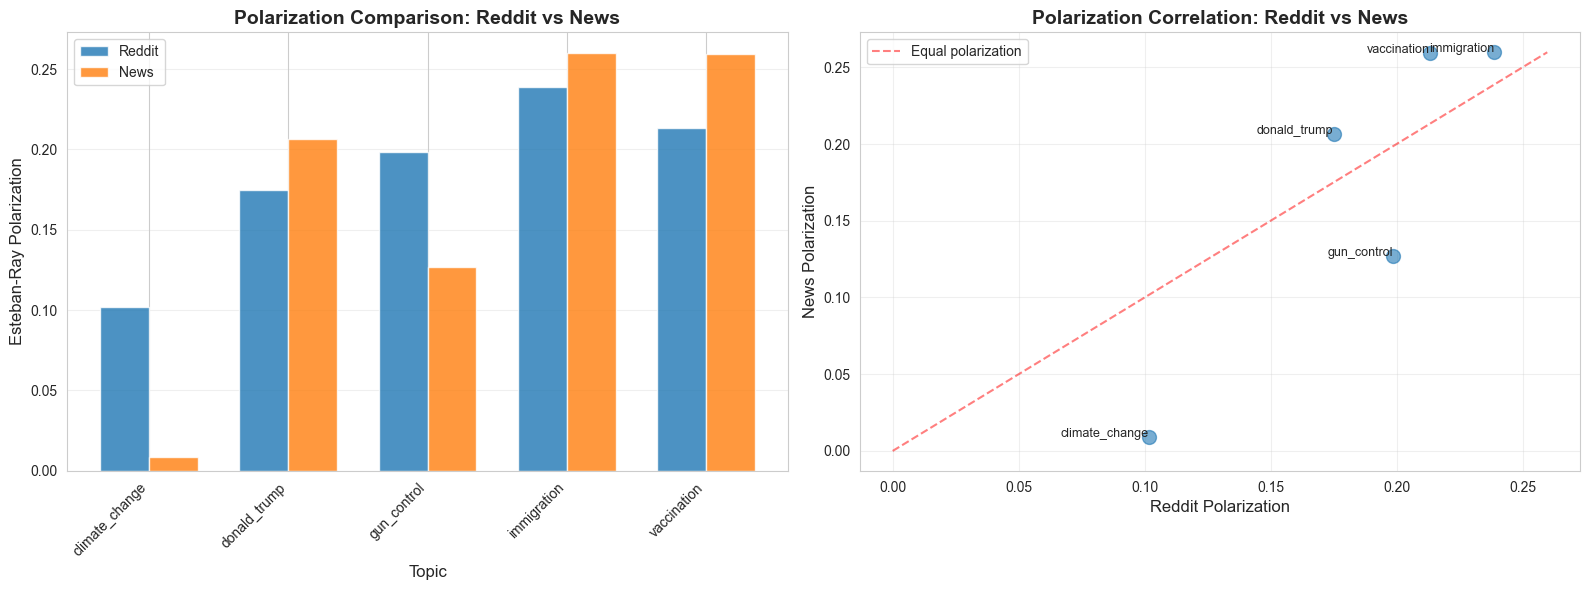


✓ Saved comparison visualization: reddit_vs_news_polarization.png


In [20]:
# Load Reddit polarization for comparison
reddit_polarization_dir = workspace_root / 'data' / '04_polarization' / 'reddit'
reddit_topic_pol_file = reddit_polarization_dir / 'polarization_by_topic.parquet'

if reddit_topic_pol_file.exists():
    print("Loading Reddit polarization data for comparison...")
    reddit_topic_pol = read_parquet(reddit_topic_pol_file)
    
    print(f"✓ Loaded Reddit polarization data")
    
    # Compare topic-level polarization
    print("\n" + "="*80)
    print("REDDIT VS NEWS POLARIZATION COMPARISON")
    print("="*80)
    
    # Create comparison dataframe
    comparison_topics = set(topic_pol_df['topic']) & set(reddit_topic_pol['topic'])
    
    if len(comparison_topics) > 0:
        print(f"\nComparing {len(comparison_topics)} common topics:")
        
        for topic in sorted(comparison_topics):
            reddit_pol = reddit_topic_pol[reddit_topic_pol['topic'] == topic]['er_polarization'].values[0]
            news_pol = topic_pol_df[topic_pol_df['topic'] == topic]['er_polarization'].values[0]
            
            print(f"\n{topic}:")
            print(f"  Reddit: {reddit_pol:.4f}")
            print(f"  News:   {news_pol:.4f}")
            print(f"  Difference: {news_pol - reddit_pol:+.4f}")
        
        # Visualize comparison
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Side-by-side bar chart
        ax = axes[0]
        reddit_vals = [reddit_topic_pol[reddit_topic_pol['topic'] == t]['er_polarization'].values[0] 
                      for t in sorted(comparison_topics)]
        news_vals = [topic_pol_df[topic_pol_df['topic'] == t]['er_polarization'].values[0] 
                    for t in sorted(comparison_topics)]
        
        x = np.arange(len(comparison_topics))
        width = 0.35
        
        ax.bar(x - width/2, reddit_vals, width, label='Reddit', alpha=0.8)
        ax.bar(x + width/2, news_vals, width, label='News', alpha=0.8)
        
        ax.set_title('Polarization Comparison: Reddit vs News', fontsize=14, fontweight='bold')
        ax.set_xlabel('Topic', fontsize=12)
        ax.set_ylabel('Esteban-Ray Polarization', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(sorted(comparison_topics), rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Scatter plot
        ax = axes[1]
        ax.scatter(reddit_vals, news_vals, s=100, alpha=0.6)
        for i, topic in enumerate(sorted(comparison_topics)):
            ax.annotate(topic, (reddit_vals[i], news_vals[i]), fontsize=9, ha='right')
        
        # Add diagonal line (x=y)
        max_val = max(max(reddit_vals), max(news_vals))
        ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal polarization')
        
        ax.set_title('Polarization Correlation: Reddit vs News', fontsize=14, fontweight='bold')
        ax.set_xlabel('Reddit Polarization', fontsize=12)
        ax.set_ylabel('News Polarization', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(news_polarization_dir / 'reddit_vs_news_polarization.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n✓ Saved comparison visualization: reddit_vs_news_polarization.png")
    else:
        print("\n⚠️  No common topics found between Reddit and News")
else:
    print(f"\n⚠️  Reddit polarization data not found: {reddit_topic_pol_file}")
    print("   Skipping cross-source comparison")

## 9. Save Results

Save polarization time series for forecasting (RQ3-4) and cross-source comparison.

In [21]:
# Save topic-level polarization
topic_pol_file = news_polarization_dir / 'polarization_by_topic.parquet'
write_parquet(topic_pol_df, topic_pol_file)
print(f"✓ Saved topic polarization: {topic_pol_file}")

# Save daily polarization time series
daily_pol_file = news_polarization_dir / 'polarization_daily.parquet'
write_parquet(daily_pol_filtered, daily_pol_file)
print(f"✓ Saved daily polarization: {daily_pol_file}")

# Save weekly polarization time series
weekly_pol_file = news_polarization_dir / 'polarization_weekly.parquet'
write_parquet(weekly_pol_filtered, weekly_pol_file)
print(f"✓ Saved weekly polarization: {weekly_pol_file}")

print(f"\nAll files saved to: {news_polarization_dir}")

✓ Wrote 5 rows to polarization_by_topic.parquet (0.0 MB)
✓ Saved topic polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news/polarization_by_topic.parquet
✓ Wrote 54 rows to polarization_daily.parquet (0.0 MB)
✓ Saved daily polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news/polarization_daily.parquet
✓ Wrote 13 rows to polarization_weekly.parquet (0.0 MB)
✓ Saved weekly polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news/polarization_weekly.parquet

All files saved to: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news


In [22]:
# Save summary statistics as JSON
summary = {
    'notebook': '25_news_polarization_esteban_ray',
    'timestamp': datetime.now().isoformat(),
    'data_period': {
        'start_date': str(df['date'].min()),
        'end_date': str(df['date'].max()),
        'total_days': int((df['date'].max() - df['date'].min()).days)
    },
    'overall_stats': {
        'total_articles': int(len(df)),
        'topics': list(df['article_topic'].unique()),
        'stance_distribution': df['stance_label'].value_counts().to_dict()
    },
    'polarization_method': {
        'metric': 'Esteban-Ray (1994)',
        'alpha': 1.6,
        'positions': {'pro': 1.0, 'against': -1.0, 'neutral': 0.0}
    },
    'topic_polarization': topic_pol_df.to_dict('records'),
    'daily_series': {
        'total_days': int(len(daily_pol_filtered)),
        'min_articles_threshold': MIN_ARTICLES_PER_DAY,
        'mean_polarization': float(daily_pol_filtered['er_polarization'].mean()),
        'std_polarization': float(daily_pol_filtered['er_polarization'].std())
    },
    'weekly_series': {
        'total_weeks': int(len(weekly_pol_filtered)),
        'min_articles_threshold': MIN_ARTICLES_PER_WEEK,
        'mean_polarization': float(weekly_pol_filtered['er_polarization'].mean()),
        'std_polarization': float(weekly_pol_filtered['er_polarization'].std())
    },
    'methodology': {
        'same_as_reddit': True,
        'stance_model_source': 'Reddit trained model (notebook 16b)',
        'enables_cross_source_comparison': True
    },
    'limitations': [
        'Stance predictions from Reddit-trained model (domain adaptation)',
        'Reddit stance model has limited performance (F1 ~0.40-0.50)',
        'donald_trump topic particularly weak (F1 0.22)',
        'Results are for pipeline validation only',
        'Final thesis requires improved stance model (F1 > 0.60)'
    ]
}

summary_file = news_polarization_dir / '25_polarization_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✓ Saved summary: {summary_file}")

✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news/25_polarization_summary.json


## 10. Summary

Final summary of news polarization analysis.

In [23]:
# Print final summary
print("\n" + "="*80)
print("NEWS POLARIZATION ANALYSIS COMPLETE")
print("="*80)

print(f"\n📊 DATA SUMMARY:")
print(f"  Total articles analyzed: {len(df):,}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Topics: {df['article_topic'].nunique()}")

print(f"\n📈 POLARIZATION METRICS:")
print(f"  Method: Esteban-Ray (1994) with α=1.6")
print(f"  Daily time points: {len(daily_pol_filtered):,} (≥{MIN_ARTICLES_PER_DAY} articles/day)")
print(f"  Weekly time points: {len(weekly_pol_filtered):,} (≥{MIN_ARTICLES_PER_WEEK} articles/week)")

print(f"\n🏆 MOST POLARIZED TOPICS:")
for i, row in enumerate(topic_pol_df.head(3).itertuples(), 1):
    print(f"  {i}. {row.topic}: {row.er_polarization:.4f}")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  • {topic_pol_file.name}")
print(f"  • {daily_pol_file.name}")
print(f"  • {weekly_pol_file.name}")
print(f"  • {summary_file.name}")
print(f"  • 6 visualization files")
if reddit_topic_pol_file.exists():
    print(f"  • reddit_vs_news_polarization.png")

print("\n" + "="*80)
print("METHODOLOGY")
print("="*80)
print(f"\n✓ Same approach as Reddit (notebook 17)")
print(f"  - Metric: Esteban-Ray with α=1.6")
print(f"  - Positions: pro=+1.0, against=-1.0, neutral=0.0")
print(f"  - Additional metrics: bipolarity, balance, extremism")
print(f"  - Enables direct cross-source comparison")

print("\n" + "="*80)
print("⚠️  IMPORTANT LIMITATIONS")
print("="*80)
print("\n🚨 INHERITED FROM STANCE DETECTION:")
print("   • Stance model trained on Reddit, applied to news (domain shift)")
print("   • Reddit stance model F1 ~0.40-0.50 (target: >0.60)")
print("   • donald_trump topic F1 ~0.22 (very poor)")
print("   • Polarization metrics inherit stance prediction errors")
print("\n📋 STATUS: Pipeline validation only, not final results")
print("\n✓ ACHIEVEMENTS:")
print("   • End-to-end pipeline demonstrated for both Reddit and News")
print("   • Cross-source comparison methodology validated")
print("   • Temporal data prepared for forecasting")
print("\n❗ FOR FINAL THESIS:")
print("   • Improve stance detection model first (Reddit + News annotations)")
print("   • Re-calculate polarization with better stance labels")
print("   • Current results demonstrate methodology, not findings")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

print("\n1. CROSS-SOURCE ANALYSIS:")
print("   - Compare Reddit vs News polarization patterns")
print("   - Analyze differences in polarization levels")
print("   - Examine temporal correlation between sources")
print("   - Create unified comparison notebook")

print("\n2. PREPARE FOR FORECASTING (RQ3-4):")
print("   - Use weekly polarization time series")
print("   - Test forecasting models (ARIMA, Prophet, LSTM)")
print("   - Compare forecasting performance across sources")
print("   - Evaluate forecast accuracy")

print("\n3. FOR FINAL THESIS:")
print("   - Annotate news-specific stance dataset (or Reddit + News)")
print("   - Train improved stance model (F1 >0.60)")
print("   - Re-run entire pipeline with better model")
print("   - Conduct final analysis and forecasting")
print("   - Document all limitations in methodology section")

print("\n" + "="*80)


NEWS POLARIZATION ANALYSIS COMPLETE

📊 DATA SUMMARY:
  Total articles analyzed: 2,559
  Date range: 2016-09-01 00:00:00 to 2016-10-31 00:00:00
  Topics: 5

📈 POLARIZATION METRICS:
  Method: Esteban-Ray (1994) with α=1.6
  Daily time points: 54 (≥10 articles/day)
  Weekly time points: 13 (≥30 articles/week)

🏆 MOST POLARIZED TOPICS:
  1. immigration: 0.2598
  2. vaccination: 0.2596
  3. donald_trump: 0.2065

✅ OUTPUTS CREATED:
  • polarization_by_topic.parquet
  • polarization_daily.parquet
  • polarization_weekly.parquet
  • 25_polarization_summary.json
  • 6 visualization files
  • reddit_vs_news_polarization.png

METHODOLOGY

✓ Same approach as Reddit (notebook 17)
  - Metric: Esteban-Ray with α=1.6
  - Positions: pro=+1.0, against=-1.0, neutral=0.0
  - Additional metrics: bipolarity, balance, extremism
  - Enables direct cross-source comparison

⚠️  IMPORTANT LIMITATIONS

🚨 INHERITED FROM STANCE DETECTION:
   • Stance model trained on Reddit, applied to news (domain shift)
   • Red